# Weblinx grounding

In [1]:
import re
import numpy as np
from datasets import load_dataset

/Users/kilian/opt/miniconda3/envs/option-agent/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
valid_data = load_dataset("McGill-NLP/weblinx", split="validation")

# filter valid data to only include columns where "action" contains "uid"
valid_uid = valid_data.filter(lambda x: "uid" in x["action"])

In [27]:
# get uids from actions
pattern = r'uid="([^"]+)"'
ideal_uids = [re.search(pattern, a).group(1) if re.search(pattern, a) else None for a in valid_uid['action'] ]

# get uids from candidates
pattern = r"[0-9a-z]{8}-[0-9a-z]{4}-[0-9a-z]{4}"
uid_candidates = [re.findall(pattern, uc) if uc is not None else [] for uc in valid_uid['candidates']]

# calculate how many ideal uids are in the candidates
cand_accs = [i in j for i, j in zip(ideal_uids, uid_candidates)]
ideal_uids_in_cand_acc = sum(cand_accs) / len(cand_accs)
print(f"Ideal uids in candidates: {ideal_uids_in_cand_acc:.2f}%")

Ideal uids in candidates: 0.67%


It is important to mention that when taking the top 50 candidates, the ideal element is present in most cases (>90%).

# Consine similarity of elements
Weblinx calculates the embeddings of the query and each element. It then scores elements based on the cosine similarity between element and query.

In [2]:
import sys
sys.path.append('../')
from weblinx_baseline.main import WeblinxGrounding
from grounding.eval import load_data

In [3]:
# find out more about consine similarities of query and elements
dataset_dir = "../datasets/wl_data/"
demo_names = ['saabwsg', 'ygprzve', 'iqaazif']
demos = load_data(dataset_dir, demo_names)

model = WeblinxGrounding()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/McGill-NLP/WebLINX-full/revision/main HTTP/1.1" 200 42376148
Fetching 0 files: 0it [00:00, ?it/s]


In [4]:
samples = model.preprocess(demos)
preds = model.predict_score(samples, group_scores=True)

INFO:root:Number of demos: 3. Starting building records.
Building input records: 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]
INFO:root:Completed. Number of input records: 5976
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: McGill-NLP/bge-small-dmr
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /McGill-NLP/bge-small-dmr/resolve/main/modules.json HTTP/1.1" 302 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /McGill-NLP/bge-small-dmr/resolve/main/config_sentence_transformers.json HTTP/1.1" 302 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /McGill-NLP/bge-small-dmr/resolve/main/README.md HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /McGill-NLP/bge-small-dmr/resolve/main/modules.json HTTP/1.1" 302 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /McGill-NLP/bge-small-dmr/resolve/mai

In [35]:
results = {
    'correct': [],
    'top_10': [],
    'max': [],
}
for demo_r in preds.values():
    scores = np.array([r['score'] for r in demo_r])
    labels = np.array([r['label'] for r in demo_r])
    correct_score = scores[labels == 1][0] if labels.sum() > 0 else np.NaN
    scores.sort()
    top_10 = scores[-10:].mean()
    max_score = scores[-1]
    results['correct'].append(correct_score)
    results['top_10'].append(top_10)
    results['max'].append(max_score)

results = {k: np.array(v) for k, v in results.items()}

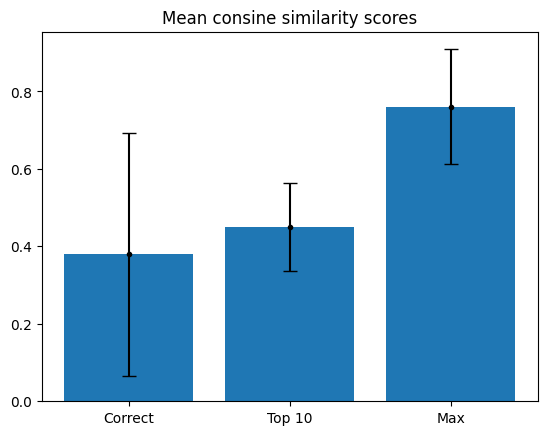

In [36]:
import matplotlib.pyplot as plt

plt.bar(['Correct', 'Top 10', 'Max'], [np.nanmean(results['correct']), results['top_10'].mean(), results['max'].mean()])
# errorbar
plt.errorbar(['Correct', 'Top 10', 'Max'], [np.nanmean(results['correct']), results['top_10'].mean(), results['max'].mean()],
             [np.nanstd(results['correct']), results['top_10'].std(), results['max'].std()], fmt='.', color='black', capsize=5)

plt.title('Mean consine similarity scores')
plt.show()

The measure of consine similarity used in Weblinx between embeddings seems to work somewhat okay but stuggles to reliably identify the "correct" element. While this seems like there is room for improvement, this analysis has the weekness that it is unknown if other elements (which are not the labeled one) are indeed related to the query or not as this information is not contained in the dataset.

# Classification

In preliminary tests we evaluated some models and also finetuned a model to only predict uids


| Model                | Correct  | In candidates | Element (IoU)
|----------------------|----------|---------------|--------------
| sLLaMA 1.3           | **0.24** | 0.76          | 20.54
| Finetuned sLLama 2.7 | 0.21     | **0.77**      | -
| Web LLama 3          | -        | -             | **27.44**


We concluded that naive fine-tuning on uids does not improve performance. Even the best reported element IoU of 27 is far away from 100, which would correspond to perfect element identification.
Further, only 67% of the correct elements are in the candidates which might be an upper bound of how good the final accuracy can get.

# Information in ideal elements
The aim of this section is to visually inspect candidates for what information they contain

In [50]:
ideal_elements = []
for i, cand_uids in enumerate(uid_candidates):
    idx = -1
    for j, cand_uid in enumerate(cand_uids):
        if cand_uid == ideal_uids[i]:
            idx = j
            break
    
    if idx == -1:
        ideal_elements.append(None)
        continue

    candidate_elements = valid_uid['candidates'][i].split('\n')
    ideal_element = candidate_elements[idx]
    ideal_elements.append(ideal_element)

In [70]:
rand_idxs = np.random.choice(len(ideal_elements), 5)

for i in rand_idxs:
    print(f"Query: {valid_uid['utterances'][i]}")
    print(f"Ideal element: {ideal_elements[i]}")
    print("")

Query: [-00:28] Hello [-00:16] Please open google calendar. [-00:00] Set up a Google Calendar event for our team brainstorming session. ;
Ideal element: (uid = 177cdce2-4b37-465d) [[tag]] input [[xpath]] /html/body/div[4.../div[1]/div/input [[bbox]] x=731 y=204.0 width=55 height=24 [[attributes]] tabindex='0' autocomplete='...37-465d' 

Query: [-00:11] Hi [00:08] Please open the Uber Eats website. ;
Ideal element: (uid = d42d0a7a-e2ba-45ec) [[tag]] a [[xpath]] /html/body/...]/span/a [[bbox]] x=452.0 y=24 width=122.4 height=48 [[attributes]] data-webtasks-...&ps=1' [[children]] div div 

Query: [-00:20] Hi [-00:08] Open google bard website. [00:49] Credentials:
	Id: webtasks.navigator@gmail.com 
	Password: KEG24qweUHij%^ ;
Ideal element: (uid = 5433b47f-d044-4e66) [[tag]] input [[xpath]] /html/body/div[.../div[1]/input [[bbox]] x=501 y=288.5 width=364 height=52 [[attributes]] data-initial-value=''...-label='Enter your password' 

Query: [-00:14] Hello ;
Ideal element: (uid = 8b9a76d2-c6

This shows that elements are *not informative* about what they do in many cases

# Conclusion

This notebook is a short investigation of how weblinx choses candidates. The main issues are
- The ideal candidates do not obtain high scores (top 50 in >90%, top 10 in ~67%)
- The candidates contain relatively little information about their functions, exemplified by low classification accuracy